### Optimal control of the ALN model
This notebook shows how to compute the optimal control (OC) signal for the ALN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

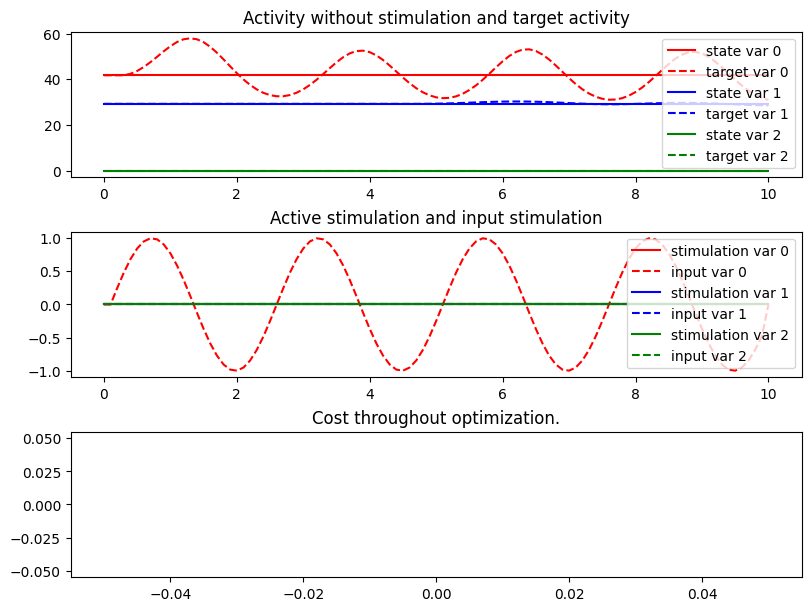

In [6]:
# We import the model
model = ALNModel()
model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.params["ext_exc_rate"] = zero_input

model.run()

# Define the result of the stimulation as target
target = getstate(model)
target_input = np.concatenate( (input,zero_input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input, zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 314.1142441134745
Cost in iteration 25: 0.13319974477141522
Cost in iteration 50: 0.02593433543798992
Cost in iteration 75: 0.010689730127626935
Cost in iteration 100: 0.006041998485074428
Cost in iteration 125: 0.003852127307255131
Cost in iteration 150: 0.0026453900852043298
Cost in iteration 175: 0.0019046751880371817
Cost in iteration 200: 0.0014171562861477957
Cost in iteration 225: 0.0010826659569918072
Cost in iteration 250: 0.0008270155029141836
Cost in iteration 275: 0.0006476929690314036
Cost in iteration 300: 0.0005134823965075342
Cost in iteration 325: 0.0004115083296948656
Cost in iteration 350: 0.00033310765819401895
Cost in iteration 375: 0.0002682470005349589
Cost in iteration 400: 0.00021896121608497765
Cost in iteration 425: 0.00017976860170418937
Cost in iteration 450: 0.00014839288101702866
Cost in iteration 475: 0.0001231515942538678
Cost in iteration 500: 0.00010277084958592912
Final cost : 0.00010277

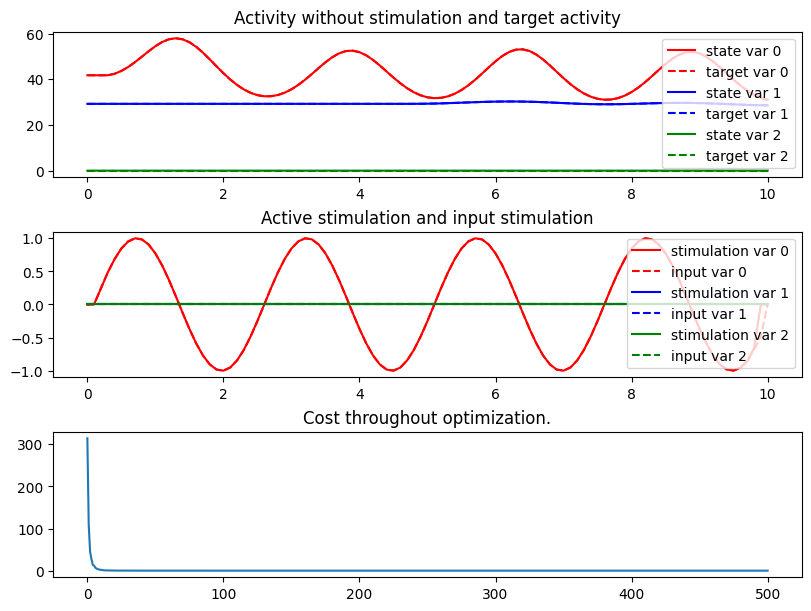

In [14]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
control_mat = np.zeros((1,3))
control_mat[0,0] = 1.
cost_mat = np.zeros((1,3))
cost_mat[0,0] = 1.


model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.00010277084958592912
Cost in iteration 25: 8.503613416352917e-05
Cost in iteration 50: 7.113196992447089e-05
Cost in iteration 75: 5.9695098965107665e-05
Cost in iteration 100: 5.02583592292553e-05
Final cost : 5.02583592292553e-05


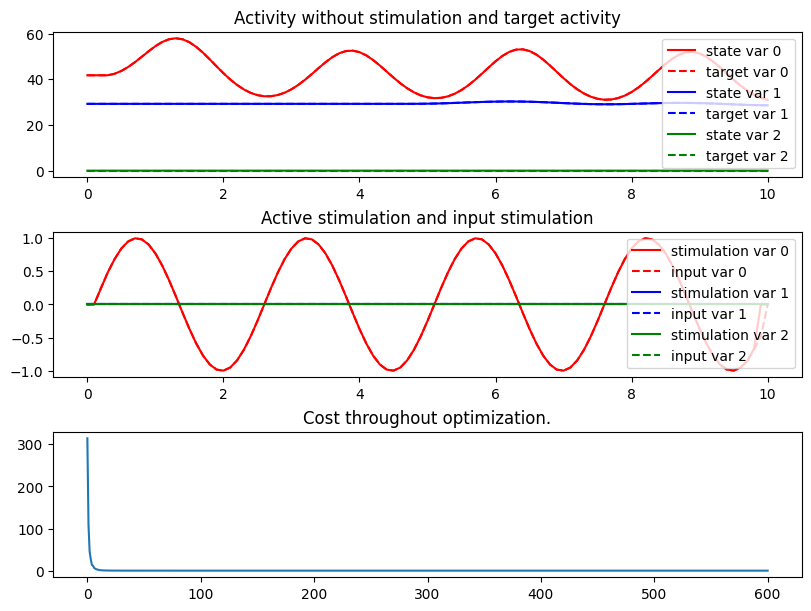

In [15]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

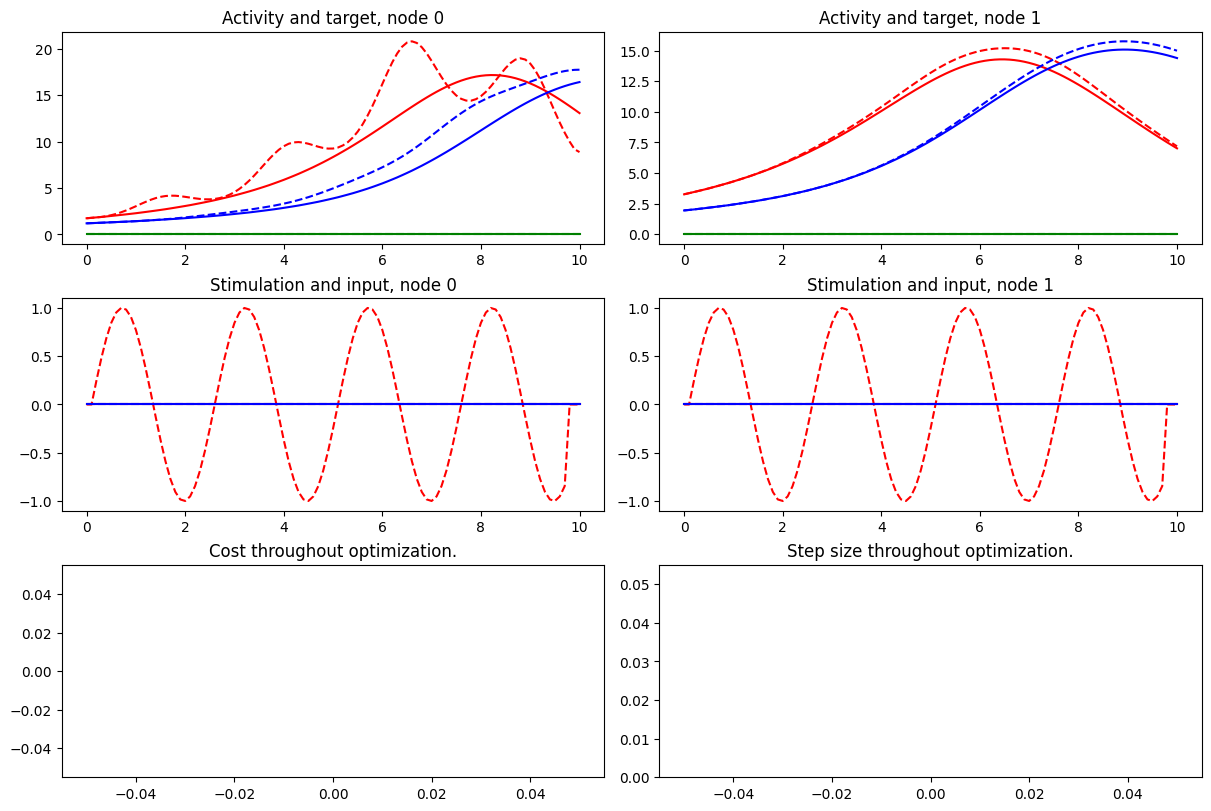

In [16]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = ALNModel(Cmat=cmat, Dmat=dmat)
model.params.de = 0.0
model.params.di = 0.0
model.run()
setinitstate(model, getfinalstate(model))

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.input_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.3, dt)/period) # other functions or random values can be used as well

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input, control_mat[0,2] * zero_input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input, control_mat[1,2] * zero_input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.params["ext_exc_rate"] = input_nw[:,2,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,1,:]
model.params["ext_exc_rate"] = zero_input_nw[:,2,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.015127687291518657
Cost in iteration 25: 2.3457677287032023e-05
Cost in iteration 50: 2.0249070782659348e-05
Cost in iteration 75: 1.957378495252409e-05
Cost in iteration 100: 1.8822464462828336e-05
Cost in iteration 125: 1.8510987094734947e-05
Cost in iteration 150: 1.8238548086318888e-05
Cost in iteration 175: 1.797422826453644e-05
Cost in iteration 200: 1.7714765351393136e-05
Cost in iteration 225: 1.746940272119397e-05
Cost in iteration 250: 1.7242004573016487e-05
Cost in iteration 275: 1.7008834954171402e-05
Cost in iteration 300: 1.6791222422416886e-05
Cost in iteration 325: 1.6579035705595427e-05
Cost in iteration 350: 1.637637432447976e-05
Cost in iteration 375: 1.6177542726605977e-05
Cost in iteration 400: 1.5987678235334517e-05
Cost in iteration 425: 1.5801097431670245e-05
Cost in iteration 450: 1.5611780933788657e-05
Cost in iteration 475: 1.5432369249991688e-05
Cost in iteration 500: 1.5258525110793503e-05
Fi

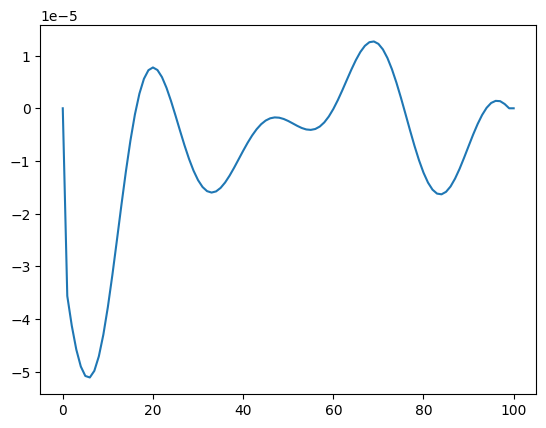

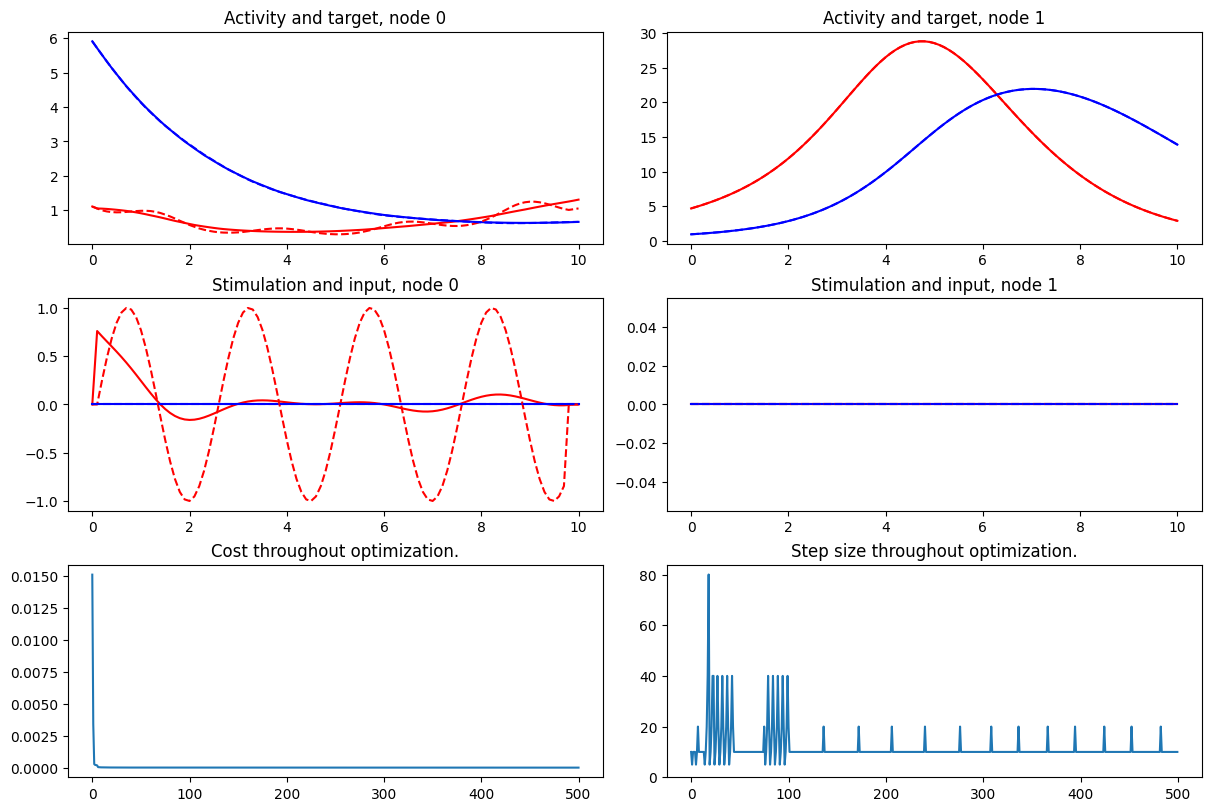

In [8]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

plt.plot(model_controlled.gradient[0,0,:])
plt.show()

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 1.5258525110793503e-05
Cost in iteration 100: 1.4596598626127715e-05
Cost in iteration 200: 1.399250685427562e-05
Cost in iteration 300: 1.343032513455385e-05
Cost in iteration 400: 1.2914449452783417e-05
Cost in iteration 500: 1.2436286142491414e-05
Cost in iteration 600: 1.1989867226354939e-05
Cost in iteration 700: 1.1567786167402607e-05
Cost in iteration 800: 1.1174367781683853e-05
Cost in iteration 900: 1.080540220195194e-05
Cost in iteration 1000: 1.0460043818706696e-05
Final cost : 1.0460043818706696e-05


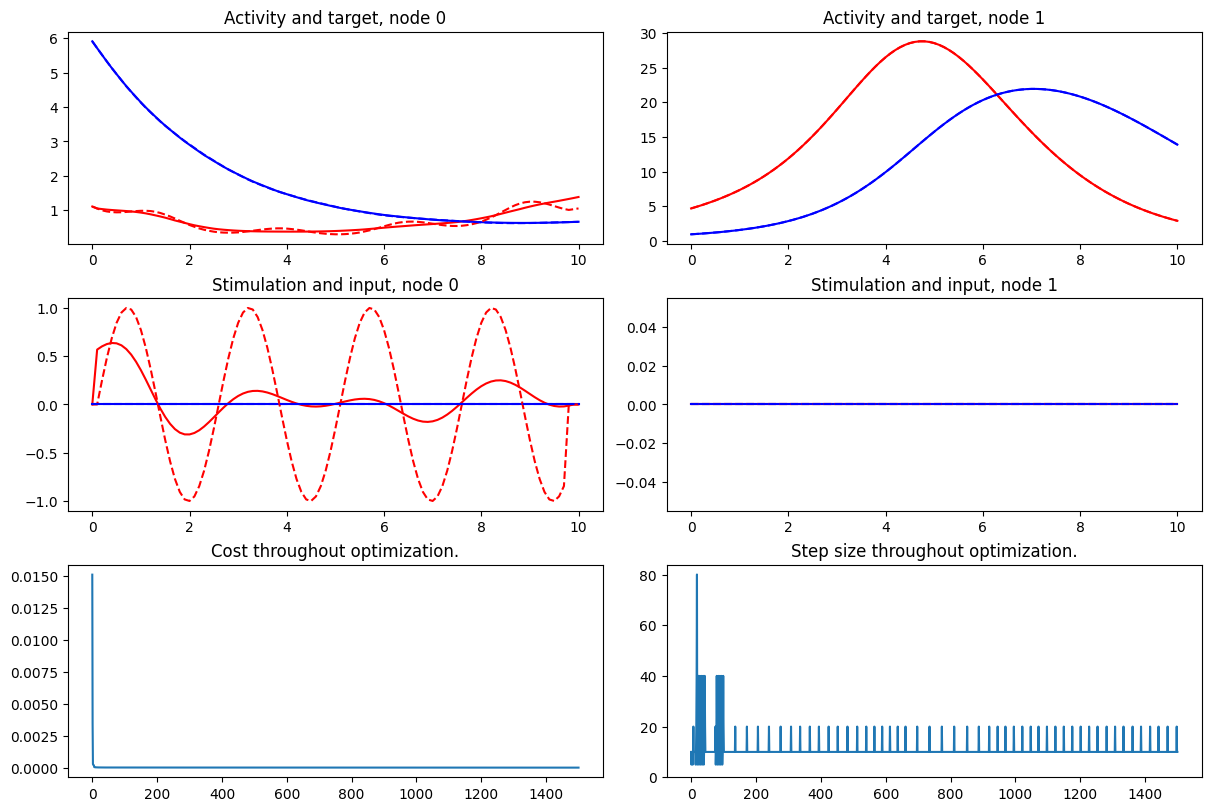

In [9]:
# Do another 1000 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.zero_step_encountered = False
model_controlled.print_array = np.arange(0,1001,100)
model_controlled.optimize(1000)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

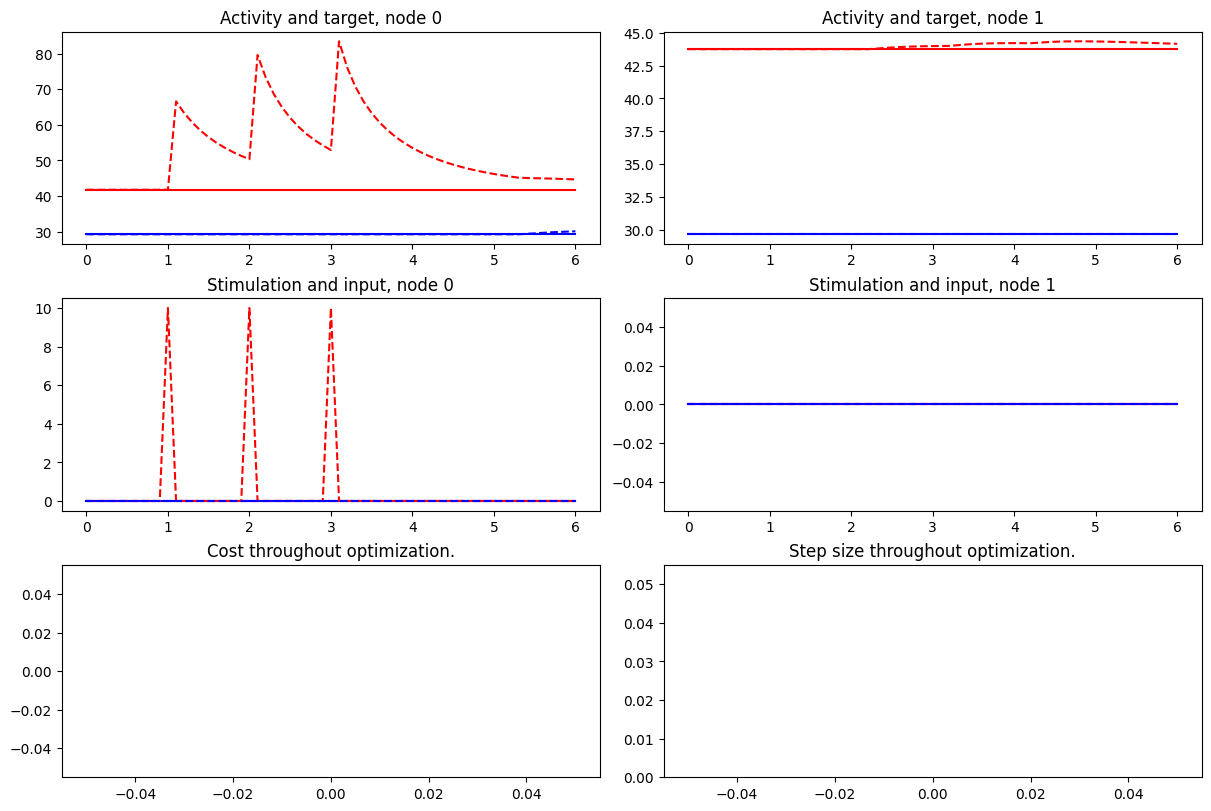

In [10]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = ALNModel(Cmat=cmat, Dmat=dmat)

model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 10. 
input[0,20] = 10.
input[0,30] = 10. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.3676959220085853
Cost in iteration 25: 0.0009647468315222048
Cost in iteration 50: 0.0007358929573827538
Cost in iteration 75: 0.0006238560018554753
Cost in iteration 100: 0.0005423485492910839
Cost in iteration 125: 0.0004790364008454826
Cost in iteration 150: 0.0004270917155816598
Cost in iteration 175: 0.0003833168978571074
Cost in iteration 200: 0.00034588939691312205
Cost in iteration 225: 0.00031401958222940235
Cost in iteration 250: 0.000286747180270869
Cost in iteration 275: 0.0002632847193485329
Cost in iteration 300: 0.00024219808614043395
Cost in iteration 325: 0.00022361585197335241
Cost in iteration 350: 0.00020718546630095786
Cost in iteration 375: 0.0001931788218117202
Cost in iteration 400: 0.0001796536694001278
Cost in iteration 425: 0.00016836247703322745
Cost in iteration 450: 0.00015803343203420848
Cost in iteration 475: 0.0001492196478358104
Cost in iteration 500: 0.0001407766040993732
Final cost : 0

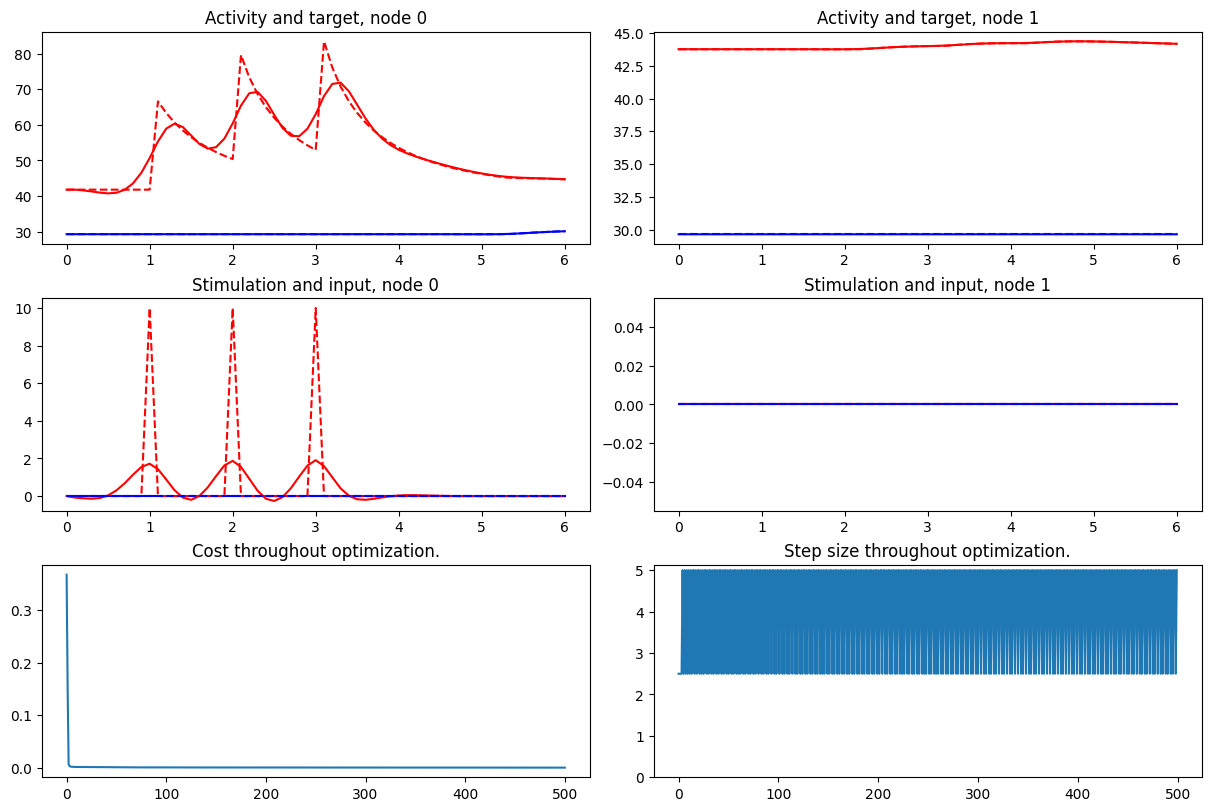

In [11]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 0.0001407766040993732
Cost in iteration 25: 0.00013345544069911602
Cost in iteration 50: 0.00012681558669287173
Cost in iteration 75: 0.00012077366902568193
Cost in iteration 100: 0.00011530269323777731
Final cost : 0.00011530269323777731


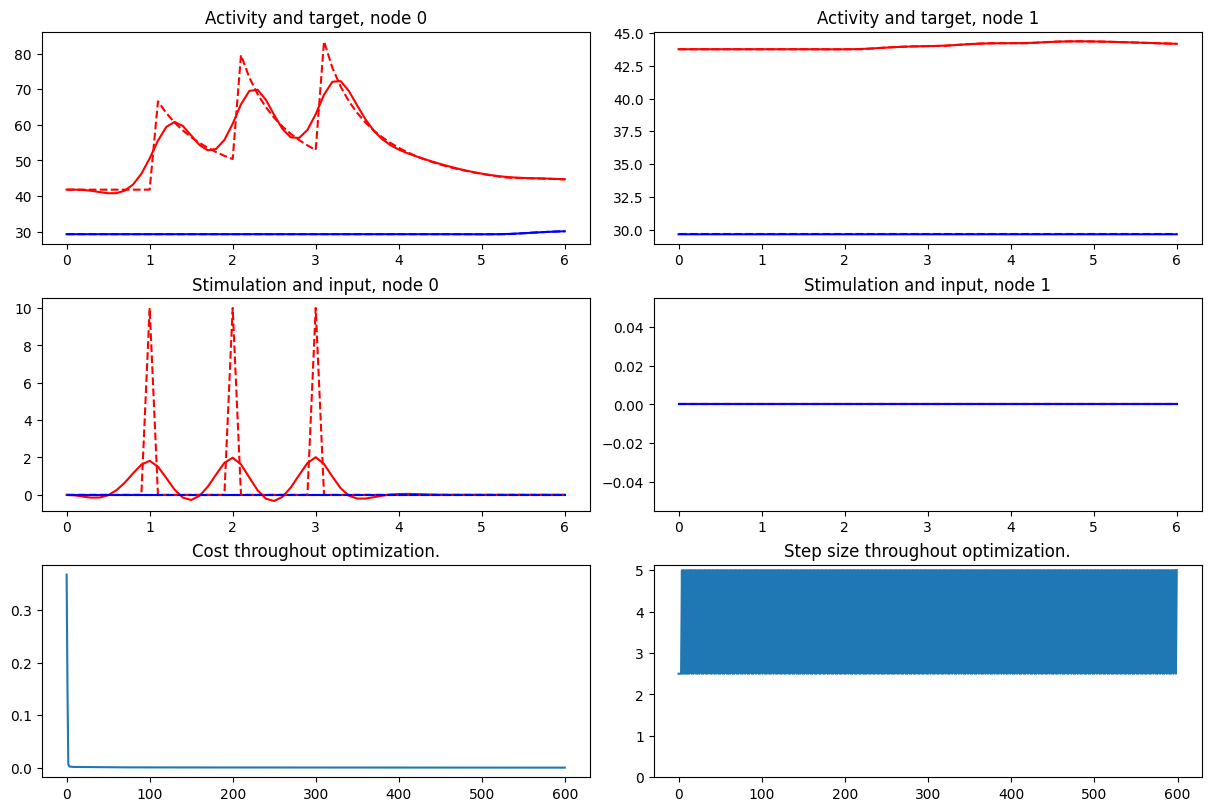

In [12]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 100 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)